# Caleb Corpuz
# DSC 630
# Final Project Code

In [1]:
# Code Reference https://github.com/RoaldSchuring/wine_recommender

In [2]:
import pandas as pd
import numpy as np
import string
from operator import itemgetter
from collections import Counter, OrderedDict
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
import nltk

## EDA

In [4]:
wine_dataframe = pd.read_csv('/Users/ccorpuz/Desktop/DSC Projects/Data/winemag-data-130k-v2.csv')

In [5]:
wine_dataframe.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


### What are the common varieties?

Text(0.5, 1.0, 'Number of Wines from the Most Common Varieties')

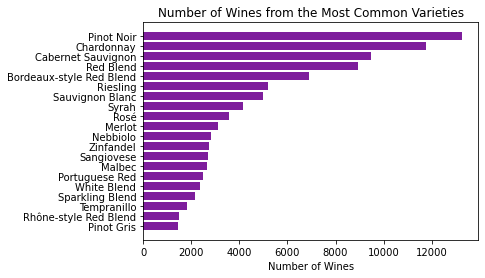

In [8]:
country_count = pd.DataFrame(wine_dataframe['variety'].value_counts().head(20))
country_count = country_count.reset_index()
country_count.columns = ['Variety', 'Count']
country_count.sort_values('Count', inplace = True)
plt.barh(y = country_count['Variety'], width = country_count['Count'], color = 'xkcd:purple')
plt.xlabel('Number of Wines')
plt.title("Number of Wines from the Most Common Varieties")

### What are the most common countries?

Text(0.5, 1.0, 'Number of Wines from the Top 10 Countries')

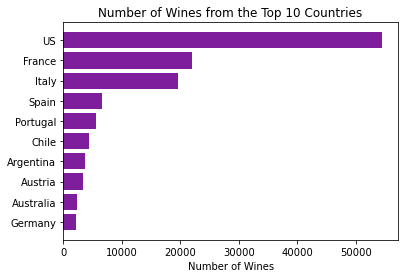

In [8]:
country_count = pd.DataFrame(wine_dataframe['country'].value_counts().head(10))
country_count = country_count.reset_index()
country_count.columns = ['Country', 'Count']
country_count.sort_values('Count', inplace = True)
plt.barh(y = country_count['Country'], width = country_count['Count'], color = 'xkcd:purple')
plt.xlabel('Number of Wines')
plt.title("Number of Wines from the Top 10 Countries")

### How much do these wines cost?

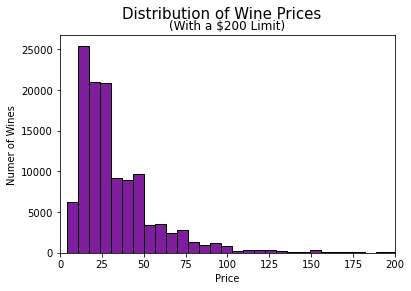

In [10]:

plt.hist(wine_dataframe['price'], bins = 500, color = 'xkcd:purple', edgecolor='black' )
plt.xlim(0,200)
plt.xlabel('Price')
plt.ylabel('Numer of Wines')
plt.suptitle('Distribution of Wine Prices', fontsize = 15)
plt.title("(With a $200 Limit)")
plt.show()

When performing some basic EDA, I saw that variety and price might be good variables to use for similarity. Most of the wines fell in the price range of under 100. There can still be a lot of variance within that price range. Someone who just wants to casually drink a bottle of wine might be willing to 15 dollars but not anything more than 50 dollars. Varieties might also be a a good indicator of similarity as varieties are tied to different types of grapes and flavors. 

### Distribution of Points

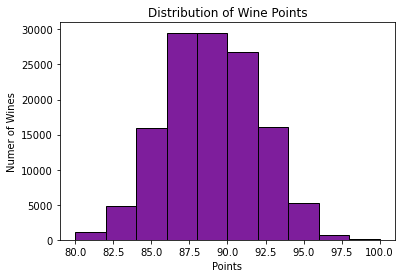

In [11]:
plt.hist(wine_dataframe['points'], bins = 10, color = 'xkcd:purple', edgecolor='black' )
# plt.xlim(0,100)
plt.xlabel('Points')
plt.ylabel('Numer of Wines')
plt.title('Distribution of Wine Points')
plt.show()

In [11]:

# The following three cells need to be ran after wine_reviews_mincount is created

all_descriptors = []
for i in wine_reviews_mincount['normalized_descriptors']:
    for k in i:
        all_descriptors.append(k)
all_desc_df = pd.DataFrame(all_descriptors, columns = ['description'])

NameError: name 'wine_reviews_mincount' is not defined

In [12]:
desc_count = pd.DataFrame(all_desc_df['description'].value_counts().head(25))
desc_count = desc_count.reset_index()
desc_count.columns = ['Description', 'Count']
desc_count.sort_values('Count', inplace = True)
plt.barh(y = desc_count['Description'], width = desc_count['Count'], color = 'xkcd:purple')
plt.xlabel('Number of Wines')
plt.title("25 Most Common Descriptors")

NameError: name 'all_desc_df' is not defined

In [13]:
unique_descriptors = []
for i in all_descriptors:
    if i not in unique_descriptors:
        unique_descriptors.append(i)
    else: 
        continue

In [14]:
print('There are',len(unique_descriptors), 'unique descriptors')

There are 0 unique descriptors


## Prepare Data

In [15]:
wine_dataframe.drop_duplicates(subset=['title'], inplace=True)

In [19]:
reviews_list = list(wine_dataframe['description'])
reviews_list = [str(r) for r in reviews_list]
full_corpus = ' '.join(reviews_list)
sentences_tokenized = sent_tokenize(full_corpus)

In [20]:
#sentences_tokenized

In [23]:
stop_words = set(stopwords.words('english')) 

punctuation_table = str.maketrans({key: None for key in string.punctuation})
sno = SnowballStemmer('english')

def normalize_text(raw_text):
    try:
        word_list = word_tokenize(raw_text)
        normalized_sentence = []
        for w in word_list:
            try:
                w = str(w)
                lower_case_word = str.lower(w)
                stemmed_word = sno.stem(lower_case_word)
                no_punctuation = stemmed_word.translate(punctuation_table)
                if len(no_punctuation) > 1 and no_punctuation not in stop_words:
                    normalized_sentence.append(no_punctuation)
            except:
                continue
        return normalized_sentence
    except:
        return ''

# sentence_sample = sentences_tokenized[:10]
normalized_sentences = []
for s in sentences_tokenized:
    normalized_text = normalize_text(s)
    normalized_sentences.append(normalized_text)

In [24]:
phrases = Phrases(normalized_sentences)
phrases = Phrases(phrases[normalized_sentences])

ngrams = Phraser(phrases)

phrased_sentences = []
for sent in normalized_sentences:
    phrased_sentence = ngrams[sent]
    phrased_sentences.append(phrased_sentence)

full_list_words = [item for sublist in phrased_sentences for item in sublist]

In [34]:
word_counts = Counter(full_list_words)
sorted_counts = OrderedDict(word_counts.most_common(5000))
counter_df = pd.DataFrame.from_dict(sorted_counts, orient='index')
# top_5000_words = counter_df.head(5000)

In [35]:
descriptor_mapping = pd.read_csv('C:/Users/Calebjc/Desktop/DSC630 Data/descriptor_mapping.csv').set_index('raw descriptor')
# descriptor_mapping

In [36]:
def return_mapped_descriptor(word):
    if word in list(descriptor_mapping.index):
        normalized_word = descriptor_mapping['level_3'][word]
        return normalized_word
    else:
        return word

normalized_sentences = []
for sent in phrased_sentences:
    normalized_sentence = []
    for word in sent:
        normalized_word = return_mapped_descriptor(word)
        normalized_sentence.append(str(normalized_word))
    normalized_sentences.append(normalized_sentence)

In [37]:
wine_word2vec_model = Word2Vec(normalized_sentences, size=300, min_count=5, iter=15)

In [38]:
wine_reviews = list(wine_dataframe['description'])

In [39]:
def return_descriptor_from_mapping(word):
    if word in list(descriptor_mapping.index):
        descriptor_to_return = descriptor_mapping['level_3'][word]
        return descriptor_to_return

In [40]:
descriptorized_reviews = []
for review in wine_reviews:
    normalized_review = normalize_text(review)
    phrased_review = ngrams[normalized_review]
    descriptors_only = [return_descriptor_from_mapping(word) for word in phrased_review]
    no_nones = [str(d) for d in descriptors_only if d is not None]
    descriptorized_review = ' '.join(no_nones)
    descriptorized_reviews.append(descriptorized_review)

In [41]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit(descriptorized_reviews)

dict_of_tfidf_weightings = dict(zip(X.get_feature_names(), X.idf_))

wine_review_vectors = []
for d in descriptorized_reviews:
    descriptor_count = 0
    weighted_review_terms = []
    terms = d.split(' ')
    for term in terms:
        if term in dict_of_tfidf_weightings.keys():
            tfidf_weighting = dict_of_tfidf_weightings[term]
            word_vector = wine_word2vec_model.wv.get_vector(term).reshape(1, 300)
            weighted_word_vector = tfidf_weighting * word_vector
            weighted_review_terms.append(weighted_word_vector)
            descriptor_count += 1
        else:
            continue
    try:
        review_vector = sum(weighted_review_terms)/len(weighted_review_terms)
    except:
        review_vector = []
    vector_and_count = [terms, review_vector, descriptor_count]
    wine_review_vectors.append(vector_and_count)

wine_dataframe['normalized_descriptors'] = list(map(itemgetter(0), wine_review_vectors))
wine_dataframe['review_vector'] = list(map(itemgetter(1), wine_review_vectors))
wine_dataframe['descriptor_count'] = list(map(itemgetter(2), wine_review_vectors))

wine_dataframe.reset_index(inplace=True)
#wine_dataframe.head()

In [42]:
### This cell below is important. We need our user input to have atleast 5 of the descriptors 
### (they need to be the descriptors from the descriptor mapping)

# first, let's eliminate any review with fewer than 5 descriptors from our dataset
wine_reviews_mincount = wine_dataframe.loc[wine_dataframe['descriptor_count'] > 5]
#wine_reviews_mincount.reset_index(inplace=True)

variety_mapping = {'Shiraz': 'Syrah', 'Pinot Gris': 'Pinot Grigio', 'Pinot Grigio/Gris': 'Pinot Grigio', 
                   'Garnacha, Grenache': 'Grenache', 'Garnacha': 'Grenache', 'CarmenÃ¨re': 'Carmenere',
                    'GrÃ¼ner Veltliner': 'Gruner Veltliner', 'TorrontÃ©s': 'Torrontes', 
                   'RhÃ´ne-style Red Blend': 'Rhone-style Red Blend', 'AlbariÃ±o': 'Albarino',
                  'GewÃ¼rztraminer': 'Gewurztraminer', 'RhÃ´ne-style White Blend': 'Rhone-style White Blend'}

def consolidate_varieties(variety_name):
    if variety_name in variety_mapping:
        return variety_mapping[variety_name]
    else:
        return variety_name

wine_reviews_clean = wine_reviews_mincount.copy()
wine_reviews_clean['variety'] = wine_reviews_clean['variety'].apply(consolidate_varieties)

# ------------------------------------------------------------------------------------------------------------

## Recommendation Based on Price, Points

# ------------------------------------------------------------------------------------------------------------

In [210]:

wine1 = wine_reviews_mincount
wine1 = wine1.dropna(axis=0)
wine1 = wine1.drop_duplicates(['title'])
#wine1 = wine1[wine1['points'] >85]
wine_pivot = wine1.pivot(index= 'title',columns='variety',values=['price']).fillna(0) # this line is supposed to have province instead of variety
wine_pivot_matrix = csr_matrix(wine_pivot)

knn = NearestNeighbors(n_neighbors=10,algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(wine_pivot_matrix)

query_index = np.random.choice(wine_pivot.shape[0])
distance, indice = model_knn.kneighbors(wine_pivot.iloc[query_index,:].values.reshape(1,-1),n_neighbors=4)
knn_list = [wine_pivot.index[query_index]]
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recmmendation for {0}:\n'.format(wine_pivot.index[query_index]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,wine_pivot.index[indice.flatten()[i]],distance.flatten()[i]))
        knn_list.append(wine_pivot.index[indice.flatten()[i]])

Recmmendation for Helix by Reininger 2005 Stillwater Creek Vineyard Merlot (Columbia Valley (WA)):

1: Red Rock 2014 Reserve Merlot (California) with distance: 0.0
2: Occasio 2011 Thatcher Bay Vineyard Merlot (Livermore Valley) with distance: 0.0
3: Kestrel 2012 Falcon Series Merlot (Yakima Valley) with distance: 0.0


In [267]:
# The above generates a random wine. Here is the saved wine that was used for the write up

saved_wine = ['Helix by Reininger 2005 Stillwater Creek Vineyard Merlot (Columbia Valley (WA))',
        'Red Rock 2014 Reserve Merlot (California)',
       'Occasio 2011 Thatcher Bay Vineyard Merlot (Livermore Valley)',
       'Kestrel 2012 Falcon Series Merlot (Yakima Valley)']

In [268]:
saved_wine[0]

'Helix by Reininger 2005 Stillwater Creek Vineyard Merlot (Columbia Valley (WA))'

In [269]:
knn_df_1 = wine_reviews_mincount[wine_reviews_mincount['title'] == saved_wine[0]]
knn_df_2 = wine_reviews_mincount[wine_reviews_mincount['title'] == saved_wine[1]]
knn_df_3 = wine_reviews_mincount[wine_reviews_mincount['title'] == saved_wine[2]]
knn_df_4 = wine_reviews_mincount[wine_reviews_mincount['title'] == saved_wine[3]]
knn_df_final = knn_df_1.append([knn_df_2, knn_df_3, knn_df_4])
knn_df_final = knn_df_final.reset_index()

#knn_df_final[['title', 'variety','normalized_descriptors','country', 'price', 'region_1']]

In [270]:
cos1 = cosine(knn_df_final['review_vector'][0], knn_df_final['review_vector'][1])
cos2 = cosine(knn_df_final['review_vector'][0], knn_df_final['review_vector'][2])
cos3 = cosine(knn_df_final['review_vector'][0], knn_df_final['review_vector'][3])

print(cos1)
print(cos2)
print(cos3)

0.2874390482902527
0.38552325963974
0.3663318157196045


In [271]:
knn_df_1 = wine_reviews_mincount[wine_reviews_mincount['title'] == knn_list[0]]
knn_df_2 = wine_reviews_mincount[wine_reviews_mincount['title'] == knn_list[1]]
knn_df_3 = wine_reviews_mincount[wine_reviews_mincount['title'] == knn_list[2]]
knn_df_4 = wine_reviews_mincount[wine_reviews_mincount['title'] == knn_list[3]]
knn_df_final = knn_df_1.append([knn_df_2, knn_df_3, knn_df_4])
knn_df_final = knn_df_final.reset_index()

knn_df_final[['title', 'variety','normalized_descriptors','country', 'price', 'region_1']]

,title,variety,normalized_descriptors,country,price,region_1
0,Helix by Reininger 2005 Stillwater Creek Viney...,Merlot,"[fruit, concentrated, clean, fruit, polished, ...",US,30.0,Columbia Valley (WA)
1,Krutz 2008 Sleepy Hollow Vineyard Chardonnay (...,Chardonnay,"[powerful, fruit, pineapple, kumquat, buttery_...",US,38.0,Santa Lucia Highlands
2,Caves Aliança 2007 Quinta das Baceladas Red (B...,Portuguese Red,"[earth, full_bodied, tannin, weight, rich, min...",Portugal,29.0,NaN
3,Maximin Grünhäuser 2015 Herrenberg Auslese 31 ...,Riesling,"[heady, tropical_fruit, pineapple, melon, mang...",Germany,114.0,NaN


# ------------------------------------------------------------------------------------------------------------

## Recommendation Based on Wine Desciption

# ------------------------------------------------------------------------------------------------------------

In [44]:
input_vectors = list(wine_reviews_mincount['review_vector'])
input_vectors_listed = [a.tolist() for a in input_vectors]
input_vectors_listed = [a[0] for a in input_vectors_listed]

In [45]:
knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric='cosine')
model_knn = knn.fit(input_vectors_listed)

In [55]:

name_test = 'Helix by Reininger 2005 Stillwater Creek Vineyard Merlot (Columbia Valley (WA))'


wine_test_vector = wine_reviews_mincount.loc[wine_reviews_mincount['title'] == name_test]['review_vector'].tolist()[0]
distance, indice = model_knn.kneighbors(wine_test_vector, n_neighbors=4)
distance_list = distance[0].tolist()[1:]
indice_list = indice[0].tolist()[1:]

main_wine = wine_reviews_mincount.loc[wine_reviews_mincount['title'] == name_test]

print('Wine to match:', name_test)
print('The original wine has the following descriptors:', list(main_wine['normalized_descriptors'])[0])
print('_________')


n = 1
knn_list = [name_test]
cosine_distances = []
for d, i in zip(distance_list, indice_list):
    wine_name = wine_reviews_mincount['title'][i]
    wine_descriptors = wine_reviews_mincount['normalized_descriptors'][i]
    print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
    print('This wine has the following descriptors:', wine_descriptors)
    print('')
    n+=1
    knn_list.append(wine_name)
    cosine_distances.append(d)
    

Wine to match: Helix by Reininger 2005 Stillwater Creek Vineyard Merlot (Columbia Valley (WA))
The original wine has the following descriptors: ['fruit', 'concentrated', 'clean', 'fruit', 'polished', 'bright', 'light_bodied', 'peppery']
_________
Suggestion 1 : Caves Aliança 2007 Quinta das Baceladas Red (Bairrada) with a cosine distance of 0.116
This wine has the following descriptors: ['earth', 'full_bodied', 'tannin', 'weight', 'rich', 'mint', 'new_wood']

Suggestion 2 : Krutz 2008 Sleepy Hollow Vineyard Chardonnay (Santa Lucia Highlands) with a cosine distance of 0.122
This wine has the following descriptors: ['powerful', 'fruit', 'pineapple', 'kumquat', 'buttery_toast', 'vanilla_cream', 'cinnamon', 'spice', 'minerality', 'nut', 'dry', 'fruit']

Suggestion 3 : La Voix 2014 She's Crafty Rosé of Pinot Noir (Sta. Rita Hills) with a cosine distance of 0.127
This wine has the following descriptors: ['cherry', 'sage', 'clove', 'iron', 'graphite', 'herb', 'spice', 'pomegranate', 'fruit']


In [48]:
knn_df_1 = wine_reviews_mincount[wine_reviews_mincount['title'] == knn_list[0]]
knn_df_2 = wine_reviews_mincount[wine_reviews_mincount['title'] == knn_list[1]]
knn_df_3 = wine_reviews_mincount[wine_reviews_mincount['title'] == knn_list[2]]
knn_df_4 = wine_reviews_mincount[wine_reviews_mincount['title'] == knn_list[3]]
knn_df_final = knn_df_1.append([knn_df_2, knn_df_3, knn_df_4])

In [53]:
knn_df_final = knn_df_final.reset_index()

In [56]:
cosine_distances

[0.11563685923119982, 0.12221678367858713, 0.12702803671190033]

In [61]:
for i in knn_df_1['normalized_descriptors']:
    print(i)

['fruit', 'concentrated', 'clean', 'fruit', 'polished', 'bright', 'light_bodied', 'peppery']
